# Creating DMN and limbic structure mask out of DiFuMo atlas 
(128 and 256 regions) - 
https://github.com/Parietal-INRIA/DiFuMo

## Importing all necessary modules and functions

In [1]:
import numpy as np
from numpy import save

from nilearn import datasets
from nilearn import image
from nilearn import regions 
from nilearn.image import index_img
from nilearn import plotting
from nilearn.plotting import find_xyz_cut_coords
from nilearn.maskers import NiftiMapsMasker

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Difumo atlas - loading everything
https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_atlas_difumo.html#nilearn.datasets.fetch_atlas_difumo

In [2]:
# for the DMN
difumo128 = datasets.fetch_atlas_difumo(dimension = 128)
difumo128_maps = difumo128['maps']
difumo128_labels = difumo128['labels']
description128 = difumo128['description']

/home/maria/miniconda3/lib/python3.8/site-packages/nilearn/datasets/atlas.py:129: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [3]:
# for Hippocampus and amygdala
difumo256 = datasets.fetch_atlas_difumo(dimension = 256)
difumo256_maps = difumo256['maps']
difumo256_labels = difumo256['labels']
description256 = difumo256['description']

## Getting the relevant labels and regions for the DMN and the Thalamus 

In [4]:
# create labels which only include component name and to what network they belong in Yeo7/17 because that is what we are interested in

# via array.dtype you can have a look at the type of elements and the header 
component_names = difumo128_labels.difumo_names
network = difumo128_labels.yeo_networks17

#labels = np.column_stack((component_names, network))
#labels.shape
#np.ndarray.view(labels)

In [5]:
# get the indices of all the dmn regions

dmn_thala_regions_index= []
network_array = np.array(network)
component_names_array = np.array(component_names)

for i in range(len(network)):

    if 'Default' in network_array[i]:
        dmn_thala_regions_index.append(i)
        
# get the index of the thalamus region 

for j in range(len(component_names)):
    if component_names[j] == 'Thalamus':
        dmn_thala_regions_index.append(j)

print(dmn_thala_regions_index)


[8, 9, 23, 25, 29, 30, 32, 34, 41, 51, 56, 57, 60, 68, 78, 89, 94, 100, 109, 116, 70]


In [6]:
# get the labels of the dmn regions
dmn_thala_labels = component_names[dmn_thala_regions_index]
dmn_thala_labels

array(['Superior frontal sulcus', 'Ventromedial prefrontal cortex',
       'Angular gyrus posterior', 'Middle temporal gyrus RH',
       'Cerebrospinal fluid (between anterior part of superior frontal gyrus and skull)',
       'Parahippocampal gyrus', 'Posterior cingulate cortex',
       'Dorsomedial prefrontal cortex antero-superior',
       'Middle temporal gyrus LH', 'Posterior cingulate cortex inferior',
       'Hippocampal fissure',
       'Dorsomedial prefrontal cortex anteromedial',
       'Parieto-occipital sulcus anterior', 'Anterior cingulate cortex',
       'Pars triangularis', 'Superior frontal sulcus anterior',
       'Retrosplenial cortex', 'Superior frontal sulcus anterior LH',
       'Angular gyrus inferior',
       'Ventromedial prefrontal cortex anterior', 'Thalamus'],
      dtype=object)

In [7]:
### get rid of cerebrospinal fluid ###
ind_csf = np.where(dmn_thala_labels == 'Cerebrospinal fluid (between anterior part of superior frontal gyrus and skull)')[0][0]
csf_index = dmn_thala_regions_index[ind_csf]
# removes from the labels list
dmn_thala_labels = np.delete(dmn_thala_labels, obj=ind_csf, axis=0)
# removes from the index list
dmn_thala_regions_index.remove(csf_index)

/home/maria/miniconda3/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/home/maria/.local/lib/python3.8/site-packages/numpy/ma/core.py:2831: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/maria/miniconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/home/maria/miniconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


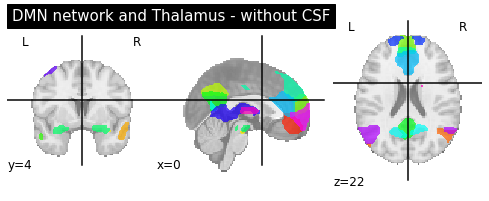

In [8]:
### check the new labels, indices and regions in brain space ###
#dmn_thala_regions_index
#dmn_thala_labels

# get the DMN regions in brain space
dmn_thala_img = index_img(difumo128_maps, dmn_thala_regions_index)
# look at the regions
plotting.plot_prob_atlas(dmn_thala_img,title="DMN network and Thalamus - without CSF", colorbar=False)

/home/maria/miniconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:1310: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fh.add_axes([fraction * index * (x1 - x0) + x0, y0,


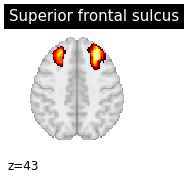

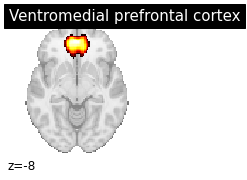

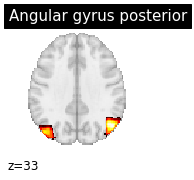

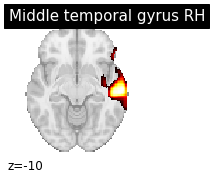

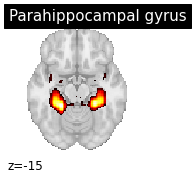

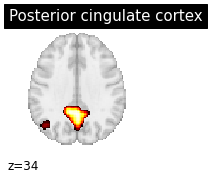

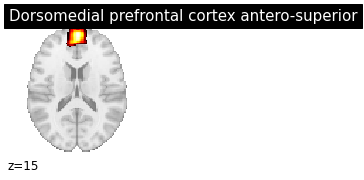

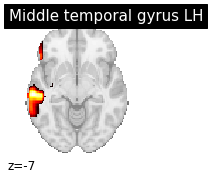

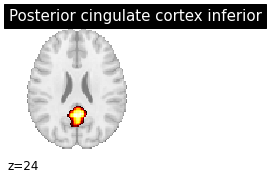

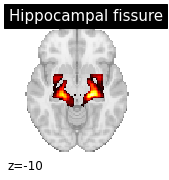

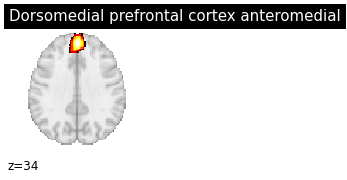

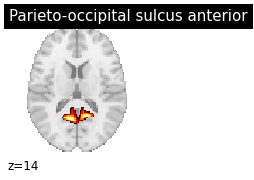

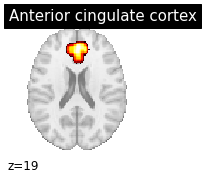

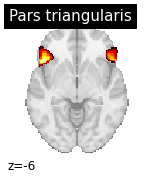

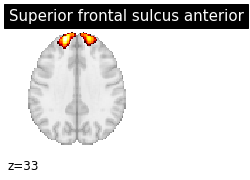

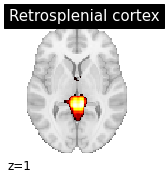

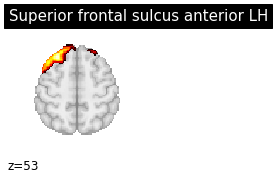

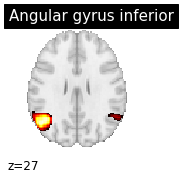

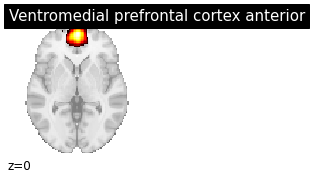

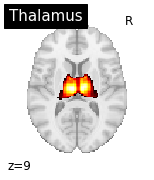

In [9]:
### check which regions still have to be separated into RH and LH ###
for i in range(len(dmn_thala_labels)):
    cur_img = index_img(dmn_thala_img, i)
    coords = find_xyz_cut_coords(cur_img)
    plotting.plot_stat_map(cur_img, display_mode='z', title = dmn_thala_labels[i], cut_coords = coords[2:3], colorbar=False)

plotting.show()

## Separate the regions which have to separated in right and left

In [10]:
# select regions which have to be separated
# superior frontal sulcus, angular gyrus posterior, parahimpocal gyrus, pars triangularis, superior frontal sulcus anterior, angular gyrus inferior
regions_to_separate = []
regions_to_separate.append(np.where(dmn_thala_labels == 'Superior frontal sulcus')[0][0])
regions_to_separate.append(np.where(dmn_thala_labels == 'Angular gyrus posterior')[0][0])
regions_to_separate.append(np.where(dmn_thala_labels == 'Parahippocampal gyrus')[0][0])
#regions_to_separate.append(np.where(dmn_thala_labels == 'Hippocampal fissure')[0][0]) # does not get separated in mode connected_components
regions_to_separate.append(np.where(dmn_thala_labels == 'Pars triangularis')[0][0])
regions_to_separate.append(np.where(dmn_thala_labels == 'Superior frontal sulcus anterior')[0][0])
regions_to_separate.append(np.where(dmn_thala_labels == 'Angular gyrus inferior')[0][0])

# only get the regions which have to be separated
tosep_dmn_img = index_img(dmn_thala_img, regions_to_separate)

In [11]:
# separate the selected regions
sep_dmn_img, index = regions.connected_regions(tosep_dmn_img, extract_type='connected_components',smoothing_fwhm = None)

# look at the regions
#plotting.plot_prob_atlas(sep_dmn_img,title="separated DMN regions", colorbar=False)

In [12]:
dmn_thala_labels[regions_to_separate]

array(['Superior frontal sulcus', 'Angular gyrus posterior',
       'Parahippocampal gyrus', 'Pars triangularis',
       'Superior frontal sulcus anterior', 'Angular gyrus inferior'],
      dtype=object)

In [13]:
index

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5]

In [14]:
sep_dmn_labels = ['Superior frontal sulcus LH', 'Superior frontal sulcus RH', 
                           'Angular gyrus posterior LH', 'Angular gyrus posterior RH',
                           'Parahippocampal gyrus LH', 'Parahippocampal gyrus RH', 
                           'Pars triangularis LH', 'Pars triangularis RH',
                           'Superior frontal sulcus anterior LH2', 'Superior frontal sulcus anterior RH',
                           'Angular gyrus inferior LH', 'Angular gyrus inferior RH']

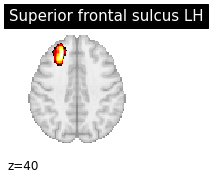

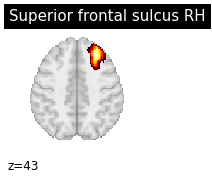

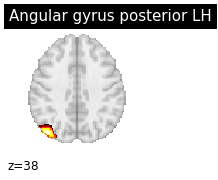

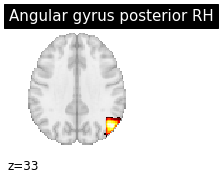

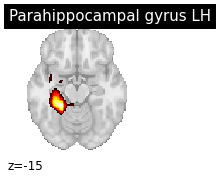

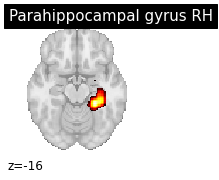

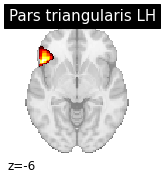

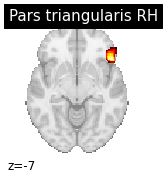

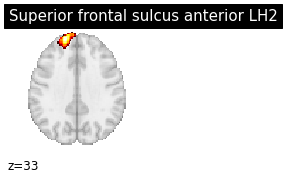

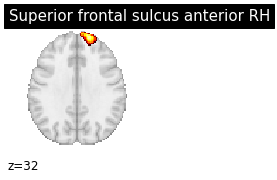

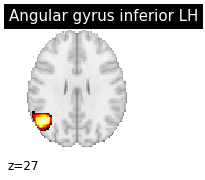

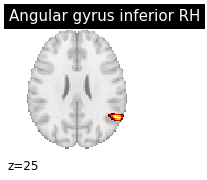

In [15]:
for i in range(len(index)):
    cur_img = index_img(sep_dmn_img, i)
    coords = find_xyz_cut_coords(cur_img)
    plotting.plot_stat_map(cur_img, display_mode='z', title= sep_dmn_labels[i], cut_coords = coords[2:3], colorbar=False)

plotting.show()

## Get the regions which are fine like they are

In [16]:
# removes from the labels list
nosep_dmn_thala_labels = np.delete(dmn_thala_labels, obj=regions_to_separate, axis=0)

no_roi_index = []

#creates the index list of the regions which were separated 
for index in regions_to_separate:
    no_roi_index.append(dmn_thala_regions_index[index])

# removes from the values of the index list
for index in no_roi_index:
    dmn_thala_regions_index.remove(index)

In [17]:
dmn_thala_regions_index

[9, 25, 32, 34, 41, 51, 56, 57, 60, 68, 94, 100, 116, 70]

In [18]:
nosep_dmn_thala_labels = component_names[dmn_thala_regions_index]
#nosep_dmn_thala_labels

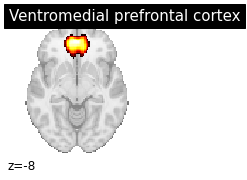

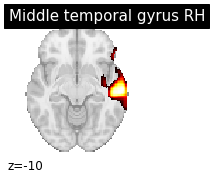

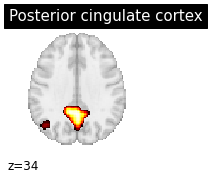

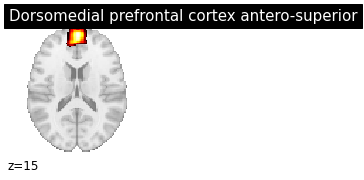

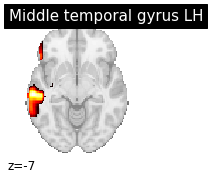

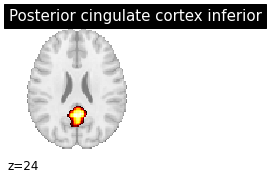

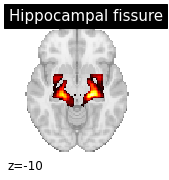

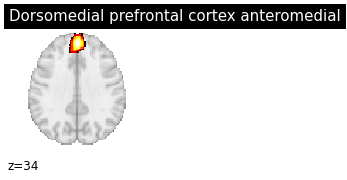

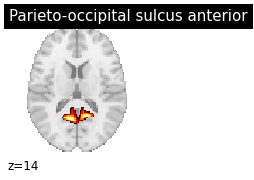

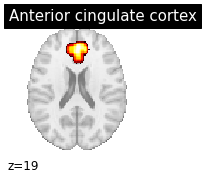

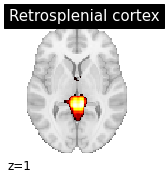

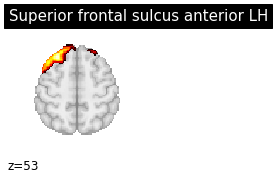

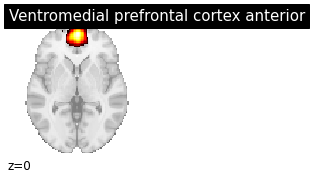

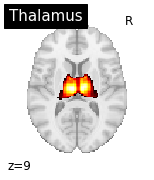

In [19]:
# get the DMN regions in brain space
nosep_dmn_thala_img = index_img(difumo128_maps, dmn_thala_regions_index)

# look at the regions
#plotting.plot_prob_atlas(nosep_dmn_thala_img,title="DMN network and Thalamus", colorbar=False)

for i in range(len(dmn_thala_regions_index)):
    cur_img = index_img(nosep_dmn_thala_img, i)
    coords = find_xyz_cut_coords(cur_img)
    plotting.plot_stat_map(cur_img, display_mode='z', title= nosep_dmn_thala_labels[i], cut_coords = coords[2:3], colorbar=False)

plotting.show()

## Getting the relevant labels and regions of the limbic structures

In [20]:
# create labels which only include component name and to what network they belong in Yeo7/17 because that is what we are interested in

# for hippocampus and amygdala
component_names256 = difumo256_labels.difumo_names
network256 = difumo256_labels.yeo_networks17

labels256 = np.column_stack((component_names256,network256))
labels256.shape
#np.ndarray.view(labels)

(256, 2)

In [21]:
hipamy_index= []
component_names_array = np.array(component_names256)

for i in range(len(component_names_array)):

    if component_names_array[i] == 'Amygdala':
        hipamy_index.append(i)
    if component_names_array[i] == 'Hippocampus posterior':
        hipamy_index.append(i)
    if component_names_array[i] == 'Hippocampus anterior':
        hipamy_index.append(i)

In [22]:
# get the labels of the amygdala and hippocampus 
hipamy_labels = labels256[hipamy_index]
#print(hipamy_labels)

In [23]:
# get the amygdala and hippocampus in brain space
hipamy_img = index_img(difumo256_maps, hipamy_index)

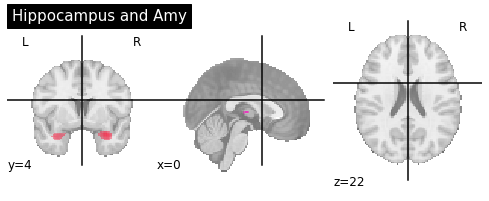

In [24]:
plotting.plot_prob_atlas(hipamy_img,title="Hippocampus and Amy", colorbar=False)

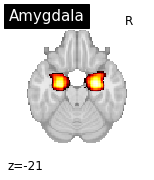

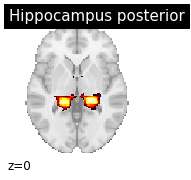

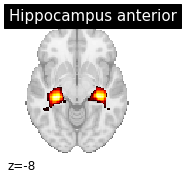

In [25]:
### if you want to check out all regions on their own ###

for i in range(len(hipamy_labels)):
    cur_img = index_img(hipamy_img, i)
    coords = find_xyz_cut_coords(cur_img)
    plotting.plot_stat_map(cur_img, display_mode='z', title = hipamy_labels[i,0], cut_coords = coords[2:3], colorbar=False)

plotting.show()

In [26]:
hipamy_labels

array([['Amygdala', 'No network found'],
       ['Hippocampus posterior', 'No network found'],
       ['Hippocampus anterior', 'DefaultC']], dtype=object)

In [27]:
new_hipamy_labels = ['Amygdala LH', 'Amygdala RH', 'Hippocampus posterior LH', 'Hippocampus posterior RH', 'Hippocampus anterior LH', 'Hippocampus anterior RH']

In [28]:
# separation of the areas
sep_hipamy_img, hipamy_index = regions.connected_regions(hipamy_img, extract_type='connected_components', smoothing_fwhm = None)

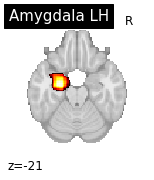

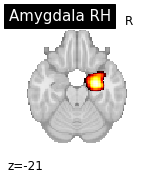

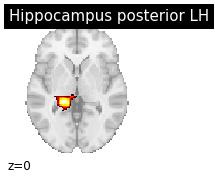

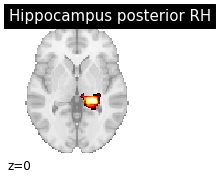

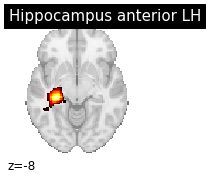

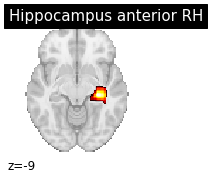

In [29]:
for i in range(len(hipamy_index)):
    cur_img = index_img(sep_hipamy_img, i)
    coords = find_xyz_cut_coords(cur_img)
    plotting.plot_stat_map(cur_img, display_mode='z', title = new_hipamy_labels[i], cut_coords = coords[2:3], colorbar=False)

plotting.show()

In [30]:
# just to be sure: check the size of all images so that they fit each other
print(nosep_dmn_thala_img.shape, sep_dmn_img.shape, sep_hipamy_img.shape)

(104, 123, 104, 14) (104, 123, 104, 12) (104, 123, 104, 6)


# Create the mask image out of DMN and limbic structures

In [31]:
# create an image of all regions 
all_regions_img = image.concat_imgs([nosep_dmn_thala_img, sep_dmn_img, sep_hipamy_img])

# create a labels list for all regions
all_region_labels = np.concatenate((nosep_dmn_thala_labels, sep_dmn_labels, new_hipamy_labels))

# check for the dimension and labels
print(all_regions_img.shape, all_region_labels)

(104, 123, 104, 32) ['Ventromedial prefrontal cortex' 'Middle temporal gyrus RH'
 'Posterior cingulate cortex'
 'Dorsomedial prefrontal cortex antero-superior'
 'Middle temporal gyrus LH' 'Posterior cingulate cortex inferior'
 'Hippocampal fissure' 'Dorsomedial prefrontal cortex anteromedial'
 'Parieto-occipital sulcus anterior' 'Anterior cingulate cortex'
 'Retrosplenial cortex' 'Superior frontal sulcus anterior LH'
 'Ventromedial prefrontal cortex anterior' 'Thalamus'
 'Superior frontal sulcus LH' 'Superior frontal sulcus RH'
 'Angular gyrus posterior LH' 'Angular gyrus posterior RH'
 'Parahippocampal gyrus LH' 'Parahippocampal gyrus RH'
 'Pars triangularis LH' 'Pars triangularis RH'
 'Superior frontal sulcus anterior LH2'
 'Superior frontal sulcus anterior RH' 'Angular gyrus inferior LH'
 'Angular gyrus inferior RH' 'Amygdala LH' 'Amygdala RH'
 'Hippocampus posterior LH' 'Hippocampus posterior RH'
 'Hippocampus anterior LH' 'Hippocampus anterior RH']


In [90]:
# show the whole mask at once
plotting.plot_prob_atlas(all_regions_img, colorbar=False, output_file = '/media/sf_shared_VB/mask_withouttitle.png')

/home/maria/miniconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


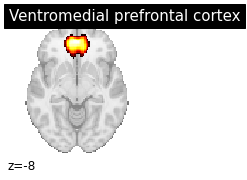

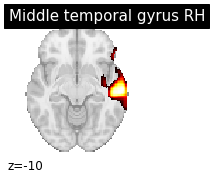

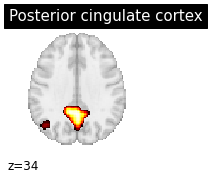

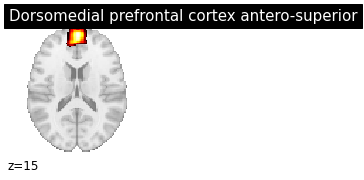

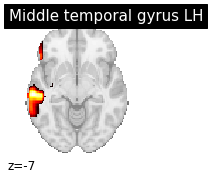

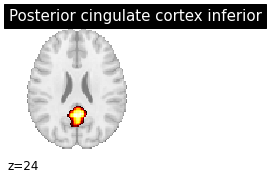

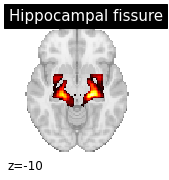

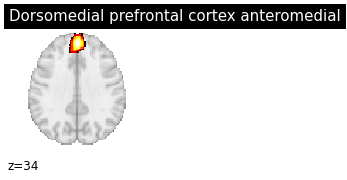

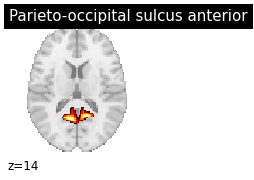

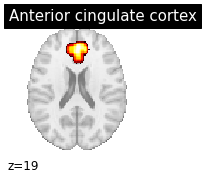

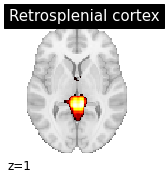

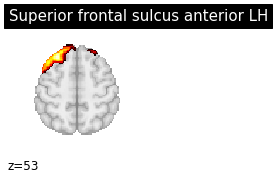

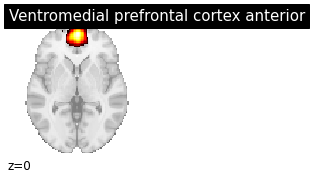

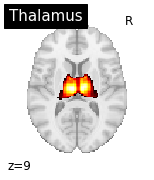

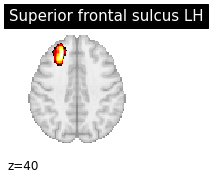

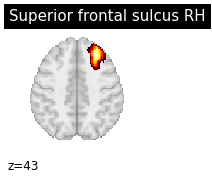

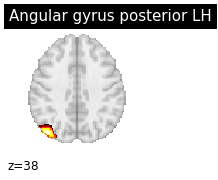

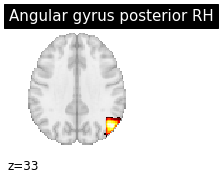

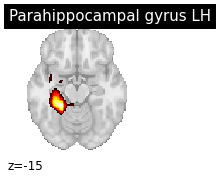

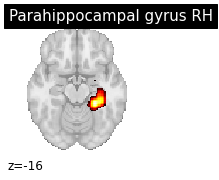

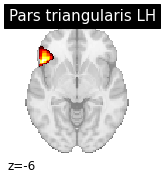

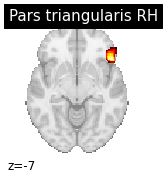

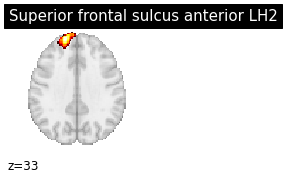

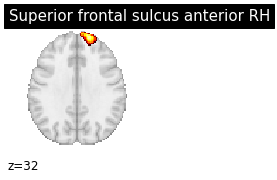

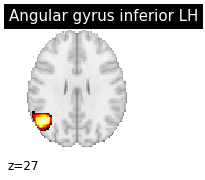

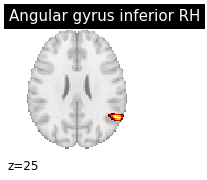

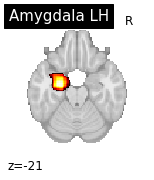

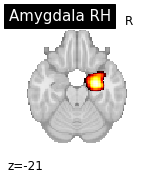

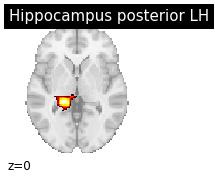

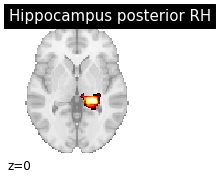

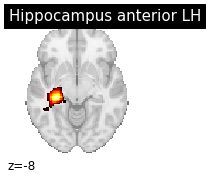

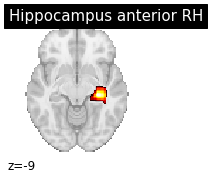

In [44]:
# shows every single component
for i in range(len(all_region_labels)):
    cur_img = index_img(all_regions_img, i)
    coords = find_xyz_cut_coords(cur_img)
    plotting.plot_stat_map(cur_img, display_mode='z', title = all_region_labels[i], cut_coords = coords[2:3], colorbar=False)

plotting.show()

In [91]:
# save all the outputs which are neede later on for further proceeding 
# save all regions as nifti file 
all_regions_img.to_filename('/media/maria/Elements/Bipolife_BIDS/A1/code/maria_thesis/dmn_limbic_2903.nii.gz')

# saving the labels as an array
save('/media/maria/Elements/Bipolife_BIDS/A1/code/maria_thesis/dmn_limbic_labels_2903', all_region_labels)